# Real-Time Sleepiness Detection System
#### prepared by : Jay patel
***

## why it is Important ?
 <font size = '3'>The development of a real-time sleepiness detection system is important because drowsy driving is a significant problem that causes numerous accidents and fatalities on the road. According to the National Highway Traffic Safety Administration (NHTSA), drowsy driving is a factor in up to 7,000 fatalities and tens of thousands of injuries each year in the United States alone. In addition to causing accidents, drowsy driving can also result in decreased reaction time, impaired decision-making, and decreased ability to focus, all of which can lead to poor driving performance and increased risk of accidents.

<font size = '3'> A real-time sleepiness detection system can help prevent these accidents by alerting drivers when they are at risk of falling asleep at the wheel. By using sensors and algorithms to analyze driver behavior and vital signs, such as eye movement, head position, heart rate, and respiration, the system can detect the early signs of sleepiness and alert the driver before they become too drowsy to safely operate the vehicle. This can help prevent accidents and save lives.

# Data collection
---
For real-time sleepiness detection system, I collect data from the Eye Dataset provided by the Visual Recognition Group at the VSB-Technical University of Ostrava. This dataset includes images of subjects performing various tasks while their eye movements and facial expressions are recorded. The Images are annotated with labels indicating the level of drowsiness exhibited by the subjects, allowing to train deep learning model to recognize the signs of sleepiness.

Link of dataset : http://mrl.cs.vsb.cz/eyedataset

In the dataset, annotated the following properties (the properties are indicated in the following order):
1. subject ID; in the dataset, we collected the data of 37 different persons (33 men and 4 women)
2. image ID; the dataset consists of 84,898 images
3. gender [0 - man, 1 - woman]; the dataset contains the information about gender for each image (man, woman)
4. glasses [0 - no, 1 - yes]; the information if the eye image contains glasses is also provided for each image (with and without the glasses)
5. eye state [0 - closed, 1 - open]; this property contains the information about two eye states (open, close)
6. reflections [0 - none, 1 - small, 2 - big]; we annotated three reflection states based on the size of reflections (none, small, and big reflections)
7. lighting conditions [0 - bad, 1 - good]; each image has two states (bad, good) based on the amount of light during capturing the videos


example:
s001_00123_0_0_0_0_0_01.png

subject ID:
xxx

image number:
xxx

gender:
0 - male
1 - famale

glasses:
0 - no
1 - yes

eye state:
0 - close
1 - open

reflections:
0 - none
1 - low
2 - high

lighting conditions/image quality:
0 - bad
1 - good





# Import all the necessary dependencies and Libraries 

In [51]:
import os
import glob
import shutil
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
from scipy import ndimage

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D,Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# separating data based on whether the eye is open or closed

# divide dataset into train and split dataset

In [5]:
source = 'C:/r/data/open'
destination = 'C:/r/data/test/open'
percent = 0.2

path, dirs, files_open = next(os.walk(source))
file_count_open = len(files_open)
percentage = file_count_open * percent
to_move = random.sample(glob.glob(source + "/*.png"), int(percentage))

for f in enumerate(to_move):
    if not os.path.exists(destination):
        os.makedirs(destination)
    shutil.move(f[1], destination)
print('moved ' + str(percentage))

moved 8590.4


In [7]:
source = 'C:/r/data/closed'
destination = 'C:/r/data/test/closed'
percent = 0.2

path, dirs, files_open = next(os.walk(source))
file_count_open = len(files_open)
percentage = file_count_open * percent
to_move = random.sample(glob.glob(source + "/*.png"), int(percentage))

for f in enumerate(to_move):
    if not os.path.exists(destination):
        os.makedirs(destination)
    shutil.move(f[1], destination)
print('moved ' + str(percentage))
    

moved 8389.2


Image loaded successfully.
Image type: <class 'numpy.ndarray'>
Image dtype: uint8
Image shape: (86, 86)


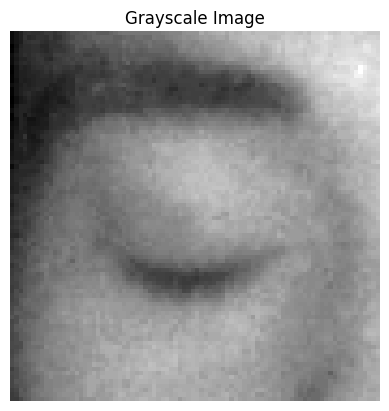

In [21]:
# Load the image in grayscale
img_path = 'C:/r/data/train/closed/s0001_00001_0_0_0_0_0_01.png'
img_ = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was successfully loaded
if img_ is None:
    print("Error: Image not loaded. Please check the file path.")
else:
    print("Image loaded successfully.")
    print(f"Image type: {type(img_)}")
    print(f"Image dtype: {img_.dtype}")
    print(f"Image shape: {img_.shape}")

    # Display the image using matplotlib
    plt.imshow(img_, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()


In [22]:
train_datagen= ImageDataGenerator(rescale=1/255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2)

train_data= train_datagen.flow_from_directory('C:/r/data/train',
                                target_size=(80,80),batch_size=8,class_mode='categorical',subset='training' )

validation_data= train_datagen.flow_from_directory('C:/r/data/train',
                                target_size=(80,80),batch_size=8,class_mode='categorical', subset='validation')

Found 54336 images belonging to 2 classes.
Found 13583 images belonging to 2 classes.


# applying normalization to all dataset

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
test_data = test_datagen.flow_from_directory('C:/r/data/test',
                                target_size=(80,80),batch_size=8,class_mode='categorical')

Found 16979 images belonging to 2 classes.


# Importing pre-trained model for training

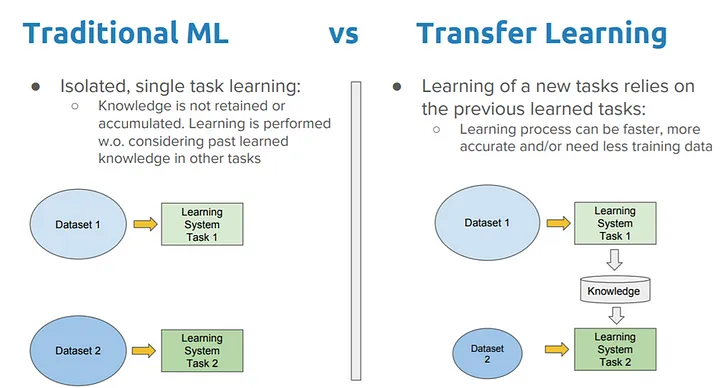

In [54]:
bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80,80,3)))
hmodel = bmodel.output
hmodel = Flatten()(hmodel)
hmodel = Dense(64, activation='relu')(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(2,activation= 'softmax')(hmodel)

model = Model(inputs=bmodel.input, outputs= hmodel)
for layer in bmodel.layers:
    layer.trainable = False

In [55]:
bmodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d_192 (Conv2D)         (None, 39, 39, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 39, 39, 32)           96        ['conv2d_192[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 39, 39, 32)           0         ['batch_normalizati

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d_192 (Conv2D)         (None, 39, 39, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 39, 39, 32)           96        ['conv2d_192[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 39, 39, 32)           0         ['batch_normalization_18

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

In [53]:
checkpoint = ModelCheckpoint('C:/r/data/models/model1',
                            monitor='val_loss',save_best_only=True,verbose=3)

earlystop = EarlyStopping(monitor = 'val_loss', patience=5, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3)

callbacks=[checkpoint,earlystop,learning_rate]

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(train_data,steps_per_epoch=train_data.samples//32,
          validation_data=validation_data,
          validation_steps=validation_data.samples//32,
          callbacks=callbacks,
          epochs=5)

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Input, Flatten, Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import scipy
from scipy import ndimage

train_datagen= ImageDataGenerator(rescale=1/255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2)
train_data= train_datagen.flow_from_directory('C:/r/data/train',
                                target_size=(80,80),batch_size=8,class_mode='categorical',subset='training' )

validation_data= train_datagen.flow_from_directory('C:/r/data/train',
                                target_size=(80,80),batch_size=8,class_mode='categorical', subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory('C:/r/data/test',
                                target_size=(80,80),batch_size=8,class_mode='categorical')

bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80,80,3)))
hmodel = bmodel.output
hmodel = Flatten()(hmodel)
hmodel = Dense(64, activation='relu')(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(2,activation= 'softmax')(hmodel)
model = Model(inputs=bmodel.input, outputs= hmodel)
for layer in bmodel.layers:
    layer.trainable = False
# bmodel.summary()
model.summary()

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('C:/r/data/models/model1',
                            monitor='val_loss',save_best_only=True,verbose=3)
earlystop = EarlyStopping(monitor = 'val_loss', patience=5, verbose= 3, restore_best_weights=True)
learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3)
callbacks=[checkpoint,earlystop,learning_rate]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_data,steps_per_epoch=train_data.samples//32,
          validation_data=validation_data,
          validation_steps=validation_data.samples//32,
          callbacks=callbacks,
          epochs=5)

Found 54336 images belonging to 2 classes.
Found 13583 images belonging to 2 classes.
Found 16979 images belonging to 2 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 39, 39, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 39, 39, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                

INFO:tensorflow:Assets written to: C:/r/data/models\model1\assets


1698/1698 [==============================] - 285s 165ms/step - loss: 0.2432 - accuracy: 0.9037 - val_loss: 0.2684 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 2/5
1698/1698 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9187
Epoch 2: val_loss improved from 0.26835 to 0.23646, saving model to C:/r/data/models\model1
INFO:tensorflow:Assets written to: C:/r/data/models\model1\assets


INFO:tensorflow:Assets written to: C:/r/data/models\model1\assets


1698/1698 [==============================] - 425s 251ms/step - loss: 0.2025 - accuracy: 0.9187 - val_loss: 0.2365 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 3/5
1698/1698 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9225
Epoch 3: val_loss did not improve from 0.23646
1698/1698 [==============================] - 326s 192ms/step - loss: 0.1950 - accuracy: 0.9225 - val_loss: 0.2586 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 4/5
1698/1698 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.9268
Epoch 4: val_loss improved from 0.23646 to 0.21271, saving model to C:/r/data/models\model1
INFO:tensorflow:Assets written to: C:/r/data/models\model1\assets


INFO:tensorflow:Assets written to: C:/r/data/models\model1\assets


1698/1698 [==============================] - 271s 160ms/step - loss: 0.1889 - accuracy: 0.9268 - val_loss: 0.2127 - val_accuracy: 0.9074 - lr: 0.0010
Epoch 5/5
1698/1698 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9326
Epoch 5: val_loss did not improve from 0.21271
1698/1698 [==============================] - 237s 140ms/step - loss: 0.1739 - accuracy: 0.9326 - val_loss: 0.2265 - val_accuracy: 0.9060 - lr: 0.0010


# accuracy 

In [2]:
acc_tr, loss_tr = model.evaluate_generator(train_data)
print(acc_tr)
print(loss_tr)

C:\Users\xingu\AppData\Local\Temp\ipykernel_9996\713691994.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc_tr, loss_tr = model.evaluate_generator(train_data)


0.15305739641189575
0.940628707408905


In [3]:
acc_vr, loss_vr = model.evaluate_generator(validation_data)
print(acc_vr)
print(loss_vr)

C:\Users\xingu\AppData\Local\Temp\ipykernel_9996\4081756742.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc_vr, loss_vr = model.evaluate_generator(validation_data)


0.22887833416461945
0.9066480398178101


In [9]:
acc_test, loss_test = model.evaluate_generator(test_data)
print(acc_tr)
print(loss_tr)

C:\Users\xingu\AppData\Local\Temp\ipykernel_9996\3655471885.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc_test, loss_test = model.evaluate_generator(test_data)


0.15305739641189575
0.940628707408905


# capturing real-time video and detecting the eye-movement and trigger the alarm if eyes are continuesly closed more than 15 seconds

In [6]:
import cv2
from tensorflow.keras.models import load_model
import numpy as np
from pygame import mixer

In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
model = load_model(r'C:/r/data/models/model1')

In [12]:
mixer.init()
sound= mixer.Sound(r'C:/r/alarm.mp3')
cap = cv2.VideoCapture(0)
Score = 0
while True:
    ret, frame = cap.read()
    height,width = frame.shape[0:2]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces= face_cascade.detectMultiScale(gray, scaleFactor= 1.2, minNeighbors=3)
    eyes= eye_cascade.detectMultiScale(gray, scaleFactor= 1.1, minNeighbors=3)
    
    cv2.rectangle(frame, (0,height-50),(200,height),(0,0,0),thickness=cv2.FILLED)
    
    for (x,y,w,h) in faces:
        cv2.rectangle(frame,pt1=(x,y),pt2=(x+w,y+h), color= (255,0,0), thickness=3 )
        
    for (ex,ey,ew,eh) in eyes:
        #cv2.rectangle(frame,pt1=(ex,ey),pt2=(ex+ew,ey+eh), color= (255,0,0), thickness=3 )
        
        
        eye= frame[ey:ey+eh,ex:ex+ew]
        eye= cv2.resize(eye,(80,80))
        eye= eye/255
        eye= eye.reshape(80,80,3)
        eye= np.expand_dims(eye,axis=0)
        
        prediction = model.predict(eye)
        if prediction[0][0]>0.30: 
            cv2.putText(frame,'closed',(10,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,fontScale=1,color=(255,255,255),
                       thickness=1,lineType=cv2.LINE_AA)
            cv2.putText(frame,'Score'+str(Score),(100,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,fontScale=1,color=(255,255,255),
                       thickness=1,lineType=cv2.LINE_AA)
            Score=Score+1
            if(Score>15):
                try:
                    sound.play()
                except:
                    pass
            
       
        elif prediction[0][1]>0.90:
            cv2.putText(frame,'open',(10,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,fontScale=1,color=(255,255,255),
                       thickness=1,lineType=cv2.LINE_AA)      
            cv2.putText(frame,'Score'+str(Score),(100,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,fontScale=1,color=(255,255,255),
                       thickness=1,lineType=cv2.LINE_AA)
            Score = Score-1
            if (Score<0):
                Score=0
            
        
    cv2.imshow('frame',frame)
    if cv2.waitKey(40) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 